# Initialization
This project assumes GitHub and Google Cloud Storage info is stored in environmental variables.  
It was developed in Google Colab, but can be run locally by selecting 'local' as the environment.  

For setup details (including required environment variables), see the README.md in the GitHub repository:  
https://github.com/tristan-day-research/NeuroStorm_seizure_detection  

In [1]:
# --- SETUP GITHUB AND GCP ENVIRONMENT VARIABLES ---
# Ensure the following environmental variables are set in Colab user data:
# - GITHUB_PAT: GitHub Personal Access Token
# - GITHUB_EMAIL: GitHub email for commits
# - GITHUB_USER_NAME: GitHub username
# - GCP_EEG_PROJECT_ID: Google Cloud Project ID
# - GCP_EEG_BUCKET_NAME: (Optional) GCP bucket for EEG data

# Select environment
ENVIRONMENT = 'colab'   # Choose 'local' or 'colab'
BRANCH_NAME = 'main'

if ENVIRONMENT == 'colab':
    from google.colab import userdata

    # Retrieve GitHub credentials from Colab user data
    token = userdata.get('GITHUB_PAT')
    github_email = userdata.get('GITHUB_EMAIL')
    github_username = userdata.get('GITHUB_USER_NAME')

    # Clone the repository (done here as the helper file isn't available yet)
    !git clone -b {BRANCH_NAME} https://{token}@github.com/tristan-day-research/NeuroStorm_seizure_detection.git

    # Change to correct directory
    %cd /content/NeuroStorm_seizure_detection/

    # Load the helper file now that the repo is cloned
    from src.setup import configure_environment

    # Run full environment setup
    bucket_name = configure_environment(environment=ENVIRONMENT)


Cloning into 'NeuroStorm_seizure_detection'...
remote: Enumerating objects: 181, done.
remote: Counting objects: 100% (181/181), done.
remote: Compressing objects: 100% (99/99), done.
remote: Total 181 (delta 84), reused 162 (delta 71), pack-reused 0 (from 0)
Receiving objects: 100% (181/181), 1.92 MiB | 13.18 MiB/s, done.
Resolving deltas: 100% (84/84), done.
/content/NeuroStorm_seizure_detection
GCP Project Set
Git configured with your user data.


In [2]:
# Standard Library Imports
import os
import gc
import json
import time
import glob
import math
import random
import threading
import subprocess
import logging
from collections import OrderedDict
from datetime import datetime
from functools import partial
from warnings import warn

# Third-Party Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import colors
plt.rcParams["font.family"] = "serif"
from tqdm import tqdm

# Machine Learning/Deep Learning Imports
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, Subset, random_split
from torch.nn.init import trunc_normal_
from torch.nn.utils import clip_grad_norm_, rnn
from torch.optim.lr_scheduler import StepLR
from torch.cuda.amp import GradScaler, autocast
from torchvision.transforms import Compose

# Check GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
!nvidia-smi

Using device: cpu
/bin/bash: line 1: nvidia-smi: command not found


# Preprocessing
Each EEG raw signal is segemnted into patches of a fixed length. Fast Fourier Transform (FFT) spectra are made from these patches which will be used to train the Vector-Quantized Variational Autoencoder (VQ-VAE).

In [19]:
print(gcp_file_prefix)

kaggle/input/hms-harmful-brain-activity-classification


In [20]:
gcp_file_prefix = userdata.get('EEG_GCP_FILEPATH')
print(gcp_file_prefix)

gcp_file_path = gcp_file_prefix + '/train_eegs'

kaggle/input/hms-harmful-brain-activity-classification


In [24]:
gcp_file_path = gcp_file_prefix.rstrip('/') + '/train_eegs'

print(gcp_file_path)

kaggle/input/hms-harmful-brain-activity-classification/train_eegs


In [30]:
%load_ext autoreload
%autoreload 2

Gathering data from /train_eegs
Found 17300 files. Visualizing...


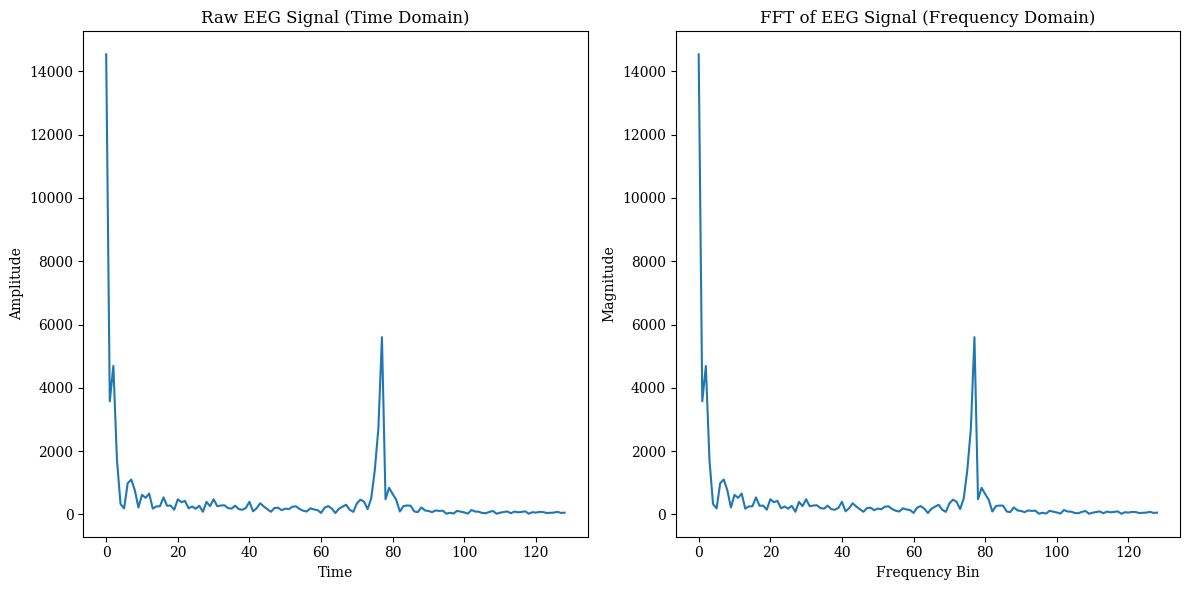

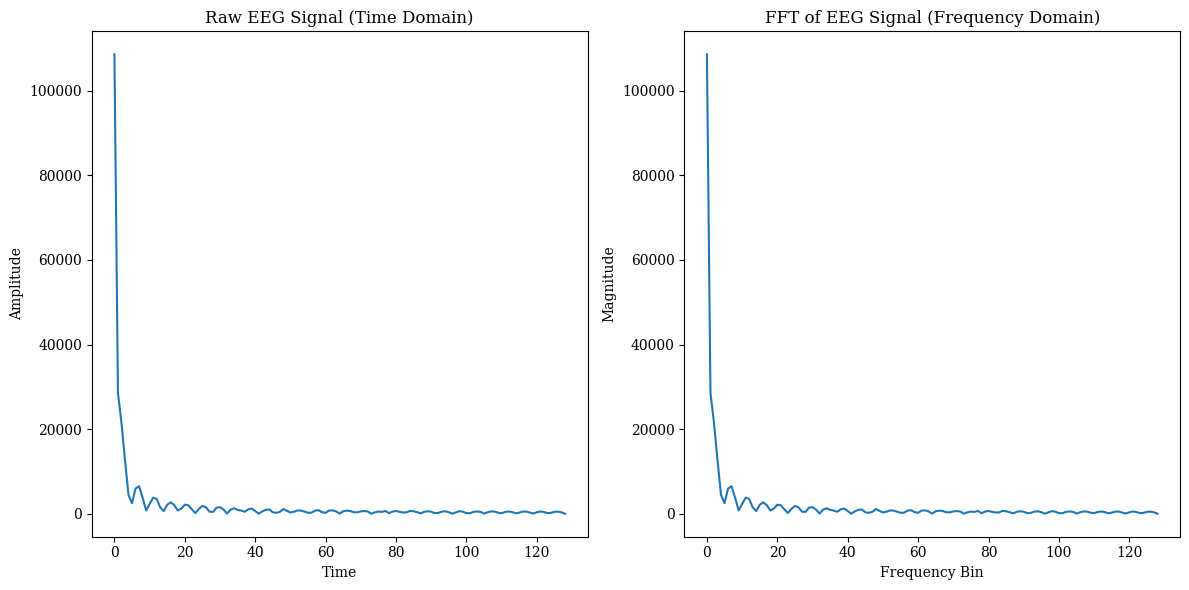

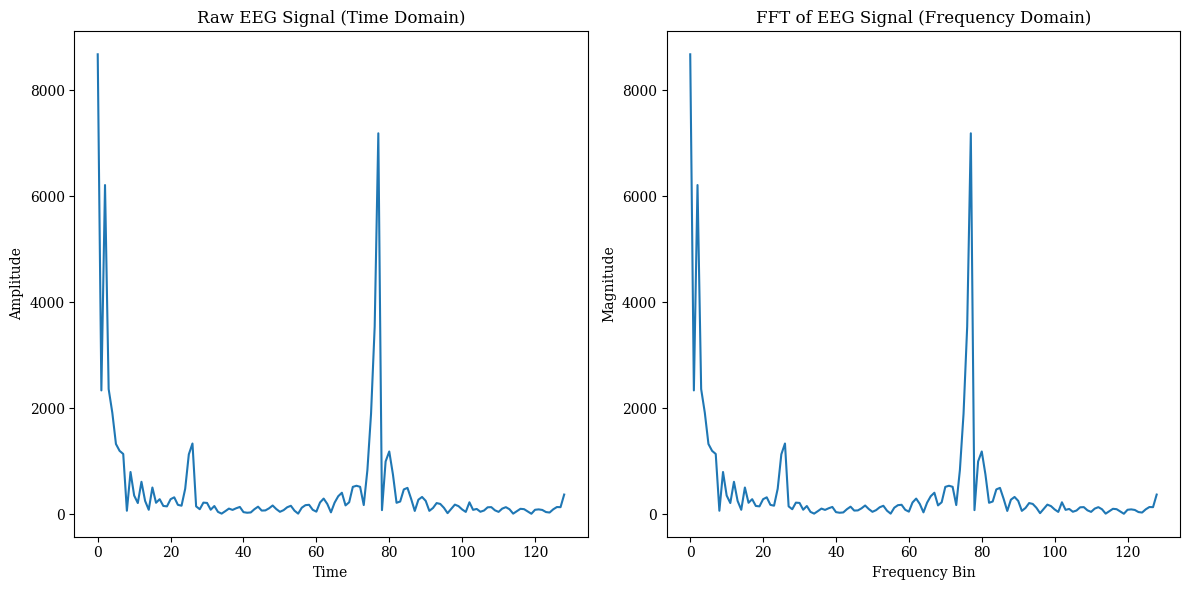

In [35]:
# gcp_filepath and gcp_bucket_name are environmental variable that are defined in setup.py

from src.data_and_FFT import EEGDataset

import importlib
from src import data_and_FFT

# Force reload of the module
importlib.reload(data_and_FFT)

# Now import the class or functions
from src.data_and_FFT import EEGDataset, visualize_eeg_and_fft

# Parameters
patch_size = 200
overlap = 50
fft_size = 256
data_dir = '/train_eegs'

# Append the data_dir to the GCP file path prefix
gcp_file_path = gcp_file_prefix.rstrip('/') + data_dir
print(f"Gathering data from {data_dir}")


# Load Dataset and Visualize
def load_and_visualize_samples(bucket_name, gcp_file_path, patch_size, overlap, fft_size):
    dataset = EEGDataset(
        bucket_name=bucket_name,
        gcp_file_path=gcp_file_path,
        patch_size=patch_size,
        overlap=overlap,
        fft_size=fft_size
    )

    print(f"Found {len(dataset)} files. Visualizing...")

    for i in range(min(3, len(dataset))):  # Visualize 3 samples or fewer
        fft_data, mask = dataset[i]
        visualize_eeg_and_fft(fft_data, fft_data, fft_size)


# Run Test
load_and_visualize_samples(
    bucket_name=bucket_name,
    gcp_file_path=gcp_file_path,
    patch_size=patch_size,
    overlap=overlap,
    fft_size=fft_size
)


# Tokenizer

In [ ]:
from src.vqvae.train import train, validate
from src.vqvae.data import EEGDataset, ToPatches
from torch.optim import AdamW
import torch

# --- Hyperparameters ---
stride = 150
batch_size = 4
num_workers = 4
num_epochs = 7
lr = 1e-4
lr_scheduler_step_size = 1
lr_scheduler_gamma = 0.9
accumulation_steps = 2

model_name = "2025_VQVAE_v1"
codebook_size = 1024
emb_dim = 64

# --- Dataset and Loader ---
transform_to_patches = ToPatches(patch_size=200, stride=stride)
eeg_dataset = EEGDataset(bucket_name=BUCKET_NAME, blob_prefix="train_eegs_HMS_processed",
                         transform=transform_to_patches)
train_size = int(0.8 * len(eeg_dataset))
valid_size = len(eeg_dataset) - train_size
train_dataset, valid_dataset = random_split(eeg_dataset, [train_size, valid_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

# --- Model, Optimizer, Scheduler ---
model_class = globals()[model_name]
model = model_class(codebook_size=codebook_size, emb_dim=emb_dim)
model.to(device)
optimizer = AdamW(model.parameters(), lr=lr, weight_decay=1e-3)
scheduler = StepLR(optimizer, step_size=lr_scheduler_step_size, gamma=lr_scheduler_gamma)

loss_function = partial(fft_masked_mse_loss, phase_start_batch=200, phase_end_batch=400)

# --- Train and Validate ---
for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1}/{num_epochs}")
    avg_loss = train(model, train_loader, optimizer, loss_function, device,
                     scheduler=scheduler, accum_steps=accumulation_steps)
    print(f"Train Loss: {avg_loss:.4f}")
    val_loss = validate(model, valid_loader, loss_function, device)
    print(f"Validation Loss: {val_loss:.4f}")
#
